# Comparing Encoder-Decoders Analysis

### Model Architecture

In [20]:
report_files = ["/Users/bking/IdeaProjects/LanguageModelRNN/experiment_results/encdec_noing23_200_512_04drb/encdec_noing23_200_512_04drb.json", "/Users/bking/IdeaProjects/LanguageModelRNN/experiment_results/encdec_noing23_bow_200_512_04drb/encdec_noing23_bow_200_512_04drb.json"]
log_files = ["/Users/bking/IdeaProjects/LanguageModelRNN/experiment_results/encdec_noing23_200_512_04drb/encdec_noing23_200_512_04drb_logs.json", "/Users/bking/IdeaProjects/LanguageModelRNN/experiment_results/encdec_noing23_bow_200_512_04drb/encdec_noing23_bow_200_512_04drb_logs.json"]
reports = []
logs = []
import json
import matplotlib.pyplot as plt
import numpy as np

for report_file in report_files:
    with open(report_file) as f:
        reports.append((report_file.split('/')[-1].split('.json')[0], json.loads(f.read())))
for log_file in log_files:
    with open(log_file) as f:
        logs.append((log_file.split('/')[-1].split('.json')[0], json.loads(f.read())))
        
for report_name, report in reports:
    print '\n', report_name, '\n'
    print 'Encoder: \n', report['architecture']['encoder']
    print 'Decoder: \n', report['architecture']['decoder']
    


encdec_noing23_200_512_04drb 

Encoder: 
nn.Sequential {
  [input -> (1) -> (2) -> (3) -> (4) -> output]
  (1): nn.LookupTable
  (2): nn.Dropout(0.400000)
  (3): nn.LSTM(200 -> 512)
  (4): nn.Dropout(0.400000)
}
Decoder: 
nn.gModule

encdec_noing23_bow_200_512_04drb 

Encoder: 
nn.Sequential {
  [input -> (1) -> (2) -> (3) -> (4) -> output]
  (1): nn.LookupTable
  (2): nn.Mean
  (3): nn.Linear(200 -> 512)
  (4): nn.Replicate
}
Decoder: 
nn.gModule


### Perplexity on Each Dataset

Model,Train Perplexity,Valid Perplexity,Test Perplexity
encdec_noing23_200_512_04drb,2.22041950514,740.070604729,893.207220523
encdec_noing23_bow_200_512_04drb,1.75150558043,912.06892427,1331.01870967


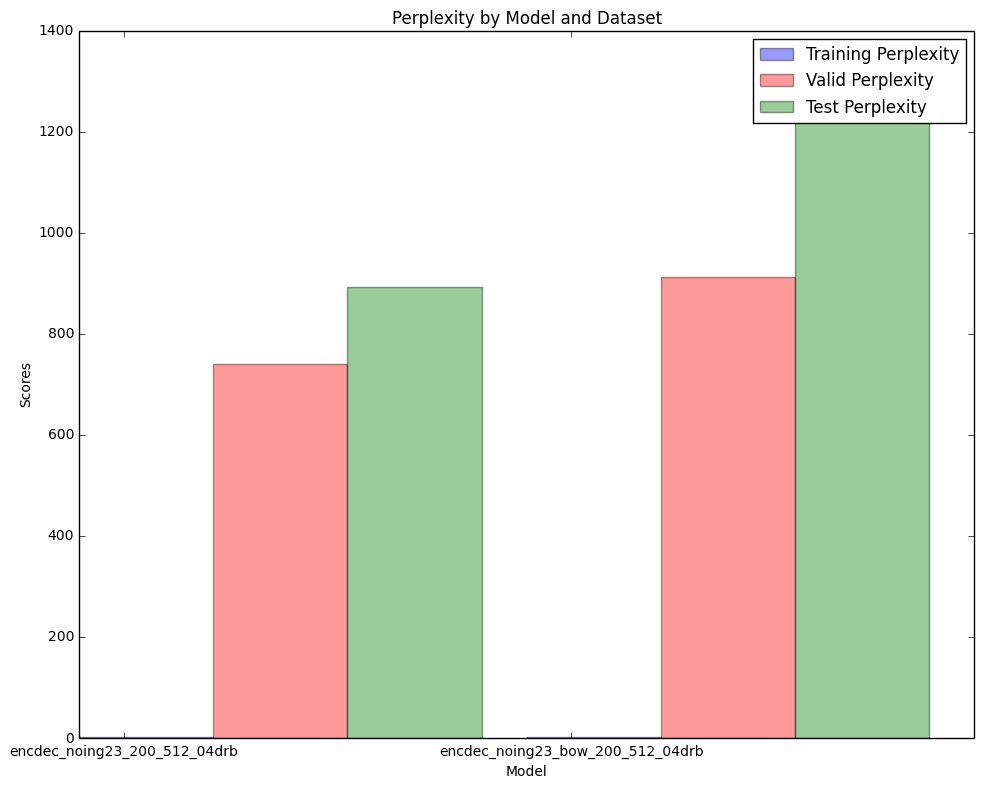

In [21]:
%matplotlib inline
from IPython.display import HTML, display

def display_table(data):
    display(HTML(
        u'<table><tr>{}</tr></table>'.format(
            u'</tr><tr>'.join(
                u'<td>{}</td>'.format('</td><td>'.join(unicode(_) for _ in row)) for row in data)
            )
    ))

def bar_chart(data):
    n_groups = len(data)
    
    train_perps = [d[1] for d in data]
    valid_perps = [d[2] for d in data]
    test_perps = [d[3] for d in data]
    
    fig, ax = plt.subplots(figsize=(10,8))
    
    index = np.arange(n_groups)
    bar_width = 0.3

    opacity = 0.4
    error_config = {'ecolor': '0.3'}

    train_bars = plt.bar(index, train_perps, bar_width,
                     alpha=opacity,
                     color='b',
                     error_kw=error_config,
                     label='Training Perplexity')

    valid_bars = plt.bar(index + bar_width, valid_perps, bar_width,
                     alpha=opacity,
                     color='r',
                     error_kw=error_config,
                     label='Valid Perplexity')
    test_bars = plt.bar(index + 2*bar_width, test_perps, bar_width,
                     alpha=opacity,
                     color='g',
                     error_kw=error_config,
                     label='Test Perplexity')

    plt.xlabel('Model')
    plt.ylabel('Scores')
    plt.title('Perplexity by Model and Dataset')
    plt.xticks(index + bar_width / 3, [d[0] for d in data])
    plt.legend()

    plt.tight_layout()
    plt.show()

data = [['<b>Model</b>', '<b>Train Perplexity</b>', '<b>Valid Perplexity</b>', '<b>Test Perplexity</b>']]

for rname, report in reports:
    data.append([rname, report['train_perplexity'], report['valid_perplexity'], report['test_perplexity']])

display_table(data)
bar_chart(data[1:])


### Loss vs. Epoch

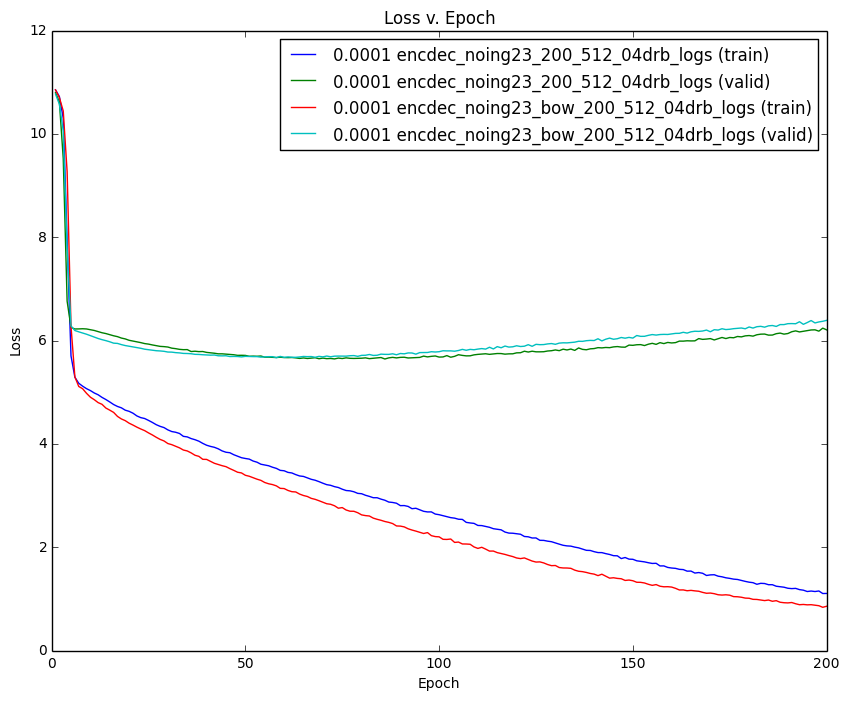

In [22]:
%matplotlib inline
plt.figure(figsize=(10, 8))
for rname, l in logs:
    for k in l.keys():
        plt.plot(l[k][0], l[k][1], label=str(k) + ' ' + rname + ' (train)')
        plt.plot(l[k][0], l[k][2], label=str(k) + ' ' + rname + ' (valid)')
plt.title('Loss v. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Perplexity vs. Epoch

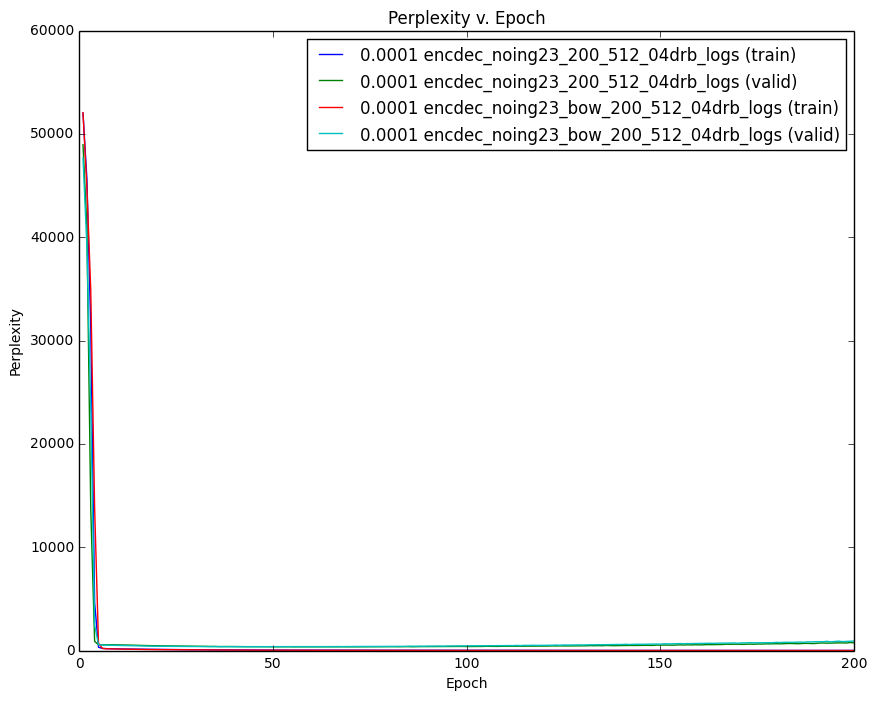

In [23]:
%matplotlib inline
plt.figure(figsize=(10, 8))
for rname, l in logs:
    for k in l.keys():
        plt.plot(l[k][0], l[k][3], label=str(k) + ' ' + rname + ' (train)')
        plt.plot(l[k][0], l[k][4], label=str(k) + ' ' + rname + ' (valid)')
plt.title('Perplexity v. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Perplexity')
plt.legend()
plt.show()

### Generations

In [24]:
def print_sample(sample, best_bleu=None):
    enc_input = ' '.join([w for w in sample['encoder_input'].split(' ') if w != '<pad>'])
    gold = ' '.join([w for w in sample['gold'].split(' ') if w != '<mask>'])
    print('Input: '+ enc_input + '\n')
    print('Gend: ' + sample['generated'] + '\n')
    print('True: ' + gold + '\n')
    if best_bleu is not None:
        cbm = ' '.join([w for w in best_bleu['best_match'].split(' ') if w != '<mask>'])
        print('Closest BLEU Match: ' + cbm + '\n')
        print('Closest BLEU Score: ' + str(best_bleu['best_score']) + '\n')
    print('\n')
    
def display_sample(samples, best_bleu=False):
    for enc_input in samples:
        data = []
        for rname, sample in samples[enc_input]:
            gold = ' '.join([w for w in sample['gold'].split(' ') if w != '<mask>'])
            data.append([rname, '<b>Generated: </b>' + sample['generated']])
            if best_bleu:
                cbm = ' '.join([w for w in sample['best_match'].split(' ') if w != '<mask>'])
                data.append([rname, '<b>Closest BLEU Match: </b>' + cbm + ' (Score: ' + str(sample['best_score']) + ')'])
        data.insert(0, ['<u><b>' + enc_input + '</b></u>', '<b>True: ' + gold+ '</b>'])
        display_table(data)

def process_samples(samples):
    # consolidate samples with identical inputs
    result = {}
    for rname, t_samples, t_cbms in samples:
        for i, sample in enumerate(t_samples):
            enc_input = ' '.join([w for w in sample['encoder_input'].split(' ') if w != '<pad>'])
            if t_cbms is not None:
                sample.update(t_cbms[i])
            if enc_input in result:
                result[enc_input].append((rname, sample))
            else:
                result[enc_input] = [(rname, sample)]
    return result


   
    


In [25]:
samples = process_samples([(rname, r['train_samples'], r['best_bleu_matches_train'] if 'best_bleu_matches_train' in r else None) for (rname, r) in reports])
display_sample(samples, best_bleu='best_bleu_matches_train' in reports[1][1])


tofu dengaku,"True: place the split peas in a fine - mesh strainer and rinse thoroughly under cold water . transfer to a large saucepan , add the"
encdec_noing23_200_512_04drb,"Generated: in a large saucepan , add all and cook until tender . add the milk , egg , and onions into 1 / 4"
encdec_noing23_200_512_04drb,"Closest BLEU Match: in a large saucepan , cook beef , onion , and garlic until meat is browned ; drain . add the (Score: 26.1585828258)"


pumpkin ravioli,True: heat oil in a soup pot or dutch oven over moderate heat until hot . add onions and fennel and cook until tender
encdec_noing23_200_512_04drb,"Generated: 1 . heat oil in a large skillet over medium heat . add the onion , and cook over medium - low heat . add"
encdec_noing23_200_512_04drb,"Closest BLEU Match: heat oil in a large skillet over medium heat . add the onion , corn and soy beans , and cook (Score: 55.6126655011)"


beef barley soup,True: in a medium size bowl whisk together eggs and cajun spice blend and set aside . in a large non stick skillet over medium
encdec_noing23_200_512_04drb,"Generated: in a large saucepan , add all and cook until tender . add the milk , egg , and onions into 1 / 4"
encdec_noing23_200_512_04drb,"Closest BLEU Match: in a large saucepan , cook beef , onion , and garlic until meat is browned ; drain . add the (Score: 26.1585828258)"


bacon - wrapped egg sandwich,True: preheat oven to 350 . slice and peel the mangoes . place mango flesh in a food processor or blender and puree for 10
encdec_noing23_200_512_04drb,Generated: preheat oven to 350 degrees f ( 175 degrees c ) . roll out pizza crust and place on a cooling rack on top
encdec_noing23_200_512_04drb,"Closest BLEU Match: preheat oven to 350 degrees f ( 175 degrees c ) . rinse the chicken pieces and place them , single layer (Score: 49.447428999)"


world 's best ribs,True: cook noodles in 4 quarts of boiling water in a large pot for 10 minutes until tender . drain . meanwhile
encdec_noing23_bow_200_512_04drb,Generated: preheat oven to 350 degrees f ( 175 degrees c ) . in a large skillet over medium - high heat . add runner
encdec_noing23_bow_200_512_04drb,Closest BLEU Match: preheat oven to 350 degrees f ( 175 degrees c ) . in a large skillet (Score: 63.1660821942)


fish in creamy sauce with cheese,"True: 1 . in a small bowl , combine the miso , tomato paste , chile - garlic paste and a"
encdec_noing23_200_512_04drb,"Generated: 1 . preheat oven to 350 degrees . 2 on a greased baking sheet , lay out the crescent seamless dough dough and dough"
encdec_noing23_200_512_04drb,"Closest BLEU Match: 1 preheat oven to 375 degrees f . 2 on a greased baking sheet , lay out the crescent seamless dough (Score: 62.2159456296)"


chopped bean `` liver ``,"True: in a large bowl , add all donut hole ingredients and blend with electric mixer until combined , about 2 - 3"
encdec_noing23_bow_200_512_04drb,Generated: preheat oven to 350 degrees f ( 175 degrees c ) . in a large skillet over medium - high heat . add runner
encdec_noing23_bow_200_512_04drb,Closest BLEU Match: preheat oven to 350 degrees f ( 175 degrees c ) . in a large skillet (Score: 63.1660821942)


petite macaroon cups,True: 1 . cook angel hair pasta according to package directions in a dutch oven ; drain . return
encdec_noing23_bow_200_512_04drb,Generated: preheat oven to 350 degrees f ( 175 degrees c ) . in a large skillet over medium - high heat . add runner
encdec_noing23_bow_200_512_04drb,Closest BLEU Match: preheat oven to 350 degrees f ( 175 degrees c ) . in a large skillet (Score: 63.1660821942)


chocolate lasagna,"True: arrange bread slices in a 12 x 8 x 2 baking dish . beat eggs with milk , grand"
encdec_noing23_bow_200_512_04drb,Generated: preheat oven to 350 degrees f ( 175 degrees c ) . in a large skillet over medium - high heat . add runner
encdec_noing23_bow_200_512_04drb,Closest BLEU Match: preheat oven to 350 degrees f ( 175 degrees c ) . in a large skillet (Score: 63.1660821942)


lemon delight mini cheesecake,True:
encdec_noing23_200_512_04drb,Generated: preheat oven to 350 degrees . cut up waffles into bite size pieces . think of them as croutons and that is is is
encdec_noing23_200_512_04drb,Closest BLEU Match: preheat oven to 350 degrees . cut up waffles into bite size pieces . think of them as croutons and that is (Score: 87.7277201636)
encdec_noing23_bow_200_512_04drb,Generated: preheat oven to 350 degrees f ( 175 degrees c ) . in a large skillet over medium - high heat . add runner
encdec_noing23_bow_200_512_04drb,Closest BLEU Match: preheat oven to 350 degrees f ( 175 degrees c ) . in a large skillet (Score: 63.1660821942)


lasagna,"True: whisk together flour , sugar , baking powder , kosher salt , and bacon . store mix"
encdec_noing23_200_512_04drb,"Generated: combine the cornmeal , flour , sugar , baking powder , and salt . add the milk , and 1 . add the"
encdec_noing23_200_512_04drb,"Closest BLEU Match: combine the cornmeal , flour , sugar , mustard , baking powder and salt , mixing well . add the milk , egg (Score: 51.4184255717)"
encdec_noing23_bow_200_512_04drb,Generated: preheat oven to 350 degrees f ( 175 degrees c ) . in a large skillet over medium - high heat . add runner
encdec_noing23_bow_200_512_04drb,Closest BLEU Match: preheat oven to 350 degrees f ( 175 degrees c ) . in a large skillet (Score: 63.1660821942)


zaru soba ( cold soba noodles ),True: 1 . preheat oven 350º f . 2 . cut one half the onion into thin slices ; place in a large bowl
encdec_noing23_bow_200_512_04drb,Generated: preheat oven to 350 degrees f ( 175 degrees c ) . in a large skillet over medium - high heat . add runner
encdec_noing23_bow_200_512_04drb,Closest BLEU Match: preheat oven to 350 degrees f ( 175 degrees c ) . in a large skillet (Score: 63.1660821942)


In [26]:
samples = process_samples([(rname, r['valid_samples'], r['best_bleu_matches_valid'] if 'best_bleu_matches_valid' in r else None) for (rname, r) in reports])
display_sample(samples, best_bleu='best_bleu_matches_valid' in reports[1][1])


,True: sprinkle scallops with salt and pepper . melt 3 tablespoons butter in very large skillet over medium -
encdec_noing23_200_512_04drb,"Generated: in a large saucepan , add all and cook until tender . add the milk , egg , and onions into 1 / 4"
encdec_noing23_200_512_04drb,"Closest BLEU Match: in a large saucepan , cook beef , onion , and garlic until meat is browned ; drain . add the (Score: 26.1585828258)"


set,"True: 1 . mix salmon and lime juice in a glass bowl . let stand , stirring occasionally , until salmon is"
encdec_noing23_bow_200_512_04drb,Generated: preheat oven to 350 degrees f ( 175 degrees c ) . in a large skillet over medium - high heat . add runner
encdec_noing23_bow_200_512_04drb,Closest BLEU Match: preheat oven to 350 degrees f ( 175 degrees c ) . in a large skillet (Score: 63.1660821942)


,"True: lightly spoon flour into dry measuring cups ; level with a knife . combine flour , baking powder , baking soda ,"
encdec_noing23_200_512_04drb,"Generated: in a large saucepan , add all and cook until tender . add the milk , egg , and onions into 1 / 4"
encdec_noing23_200_512_04drb,"Closest BLEU Match: in a large saucepan , cook beef , onion , and garlic until meat is browned ; drain . add the (Score: 26.1585828258)"
encdec_noing23_200_512_04drb,"Generated: in a large saucepan , add all and cook until tender . add the milk , egg , and onions into 1 / 4"
encdec_noing23_200_512_04drb,"Closest BLEU Match: in a large saucepan , cook beef , onion , and garlic until meat is browned ; drain . add the (Score: 26.1585828258)"
encdec_noing23_200_512_04drb,"Generated: in a large saucepan , add all and cook until tender . add the milk , egg , and onions into 1 / 4"
encdec_noing23_200_512_04drb,"Closest BLEU Match: in a large saucepan , cook beef , onion , and garlic until meat is browned ; drain . add the (Score: 26.1585828258)"
encdec_noing23_bow_200_512_04drb,Generated: preheat oven to 350 degrees f ( 175 degrees c ) . in a large skillet over medium - high heat . add runner
encdec_noing23_bow_200_512_04drb,Closest BLEU Match: preheat oven to 350 degrees f ( 175 degrees c ) . in a large skillet (Score: 63.1660821942)
encdec_noing23_bow_200_512_04drb,Generated: preheat oven to 350 degrees f ( 175 degrees c ) . in a large skillet over medium - high heat . add runner
encdec_noing23_bow_200_512_04drb,Closest BLEU Match: preheat oven to 350 degrees f ( 175 degrees c ) . in a large skillet (Score: 63.1660821942)


pulled,"True: in a food processor or food mill , grind or mince beans until fine . saute onion in oil until"
encdec_noing23_200_512_04drb,"Generated: in a large saucepan , add all and cook until tender . add the milk , egg , and onions into 1 / 4"
encdec_noing23_200_512_04drb,"Closest BLEU Match: in a large saucepan , cook beef , onion , and garlic until meat is browned ; drain . add the (Score: 26.1585828258)"
encdec_noing23_200_512_04drb,"Generated: in a large saucepan , add all and cook until tender . add the milk , egg , and onions into 1 / 4"
encdec_noing23_200_512_04drb,"Closest BLEU Match: in a large saucepan , cook beef , onion , and garlic until meat is browned ; drain . add the (Score: 26.1585828258)"


pulled pulled,"True: in a medium bowl , stir together the tomatoes , 1 / 4 cup of water ,"
encdec_noing23_200_512_04drb,"Generated: in a large saucepan , add all and cook until tender . add the milk , egg , and onions into 1 / 4"
encdec_noing23_200_512_04drb,"Closest BLEU Match: in a large saucepan , cook beef , onion , and garlic until meat is browned ; drain . add the (Score: 26.1585828258)"


pulled,"True: in a large bowl , mix together sesame seeds , egg whites , cornstarch , salt and pepper ."
encdec_noing23_bow_200_512_04drb,Generated: preheat oven to 350 degrees f ( 175 degrees c ) . in a large skillet over medium - high heat . add runner
encdec_noing23_bow_200_512_04drb,Closest BLEU Match: preheat oven to 350 degrees f ( 175 degrees c ) . in a large skillet (Score: 63.1660821942)


pulled set,"True: trim all white membrane and fat from the filet and chop into bite size pieces , set aside . dice the"
encdec_noing23_bow_200_512_04drb,Generated: preheat oven to 350 degrees f ( 175 degrees c ) . in a large skillet over medium - high heat . add runner
encdec_noing23_bow_200_512_04drb,Closest BLEU Match: preheat oven to 350 degrees f ( 175 degrees c ) . in a large skillet (Score: 63.1660821942)


In [27]:
samples = process_samples([(rname, r['test_samples'], r['best_bleu_matches_test'] if 'best_bleu_matches_test' in r else None) for (rname, r) in reports])
display_sample(samples, best_bleu='best_bleu_matches_test' in reports[1][1])

charbroiled oysters from dragos,True: heat the grill to med - high . melt butter with garlic and pepper in a large
encdec_noing23_bow_200_512_04drb,Generated: preheat oven to 350 degrees f ( 175 degrees c ) . in a large skillet over medium - high heat . add runner
encdec_noing23_bow_200_512_04drb,Closest BLEU Match: preheat oven to 350 degrees f ( 175 degrees c ) . in a large skillet (Score: 63.1660821942)


peanut butter pancakes,"True: in a medium bowl , combine the flour , sugar , baking powder and salt ."
encdec_noing23_bow_200_512_04drb,Generated: preheat oven to 350 degrees f ( 175 degrees c ) . in a large skillet over medium - high heat . add runner
encdec_noing23_bow_200_512_04drb,Closest BLEU Match: preheat oven to 350 degrees f ( 175 degrees c ) . in a large skillet (Score: 63.1660821942)


moroccan pot roast with potatoes and carrots,"True: 1 . coat the inside of a slow cooker with cooking spray . combine tomato paste , broth"
encdec_noing23_200_512_04drb,Generated: preheat oven to 350 degrees f ( 175 degrees c ) . roll out pizza crust and place on a cooling rack on top
encdec_noing23_200_512_04drb,"Closest BLEU Match: preheat oven to 350 degrees f ( 175 degrees c ) . rinse the chicken pieces and place them , single layer (Score: 49.447428999)"


quick and easy white bean salad,"True: 1 after you chop up the onion , squeeze a little lemon juice over it and let it sit while prepping"
encdec_noing23_200_512_04drb,Generated: preheat oven to 350 degrees f ( 175 degrees c ) . roll out pizza crust and place on a cooling rack on top
encdec_noing23_200_512_04drb,"Closest BLEU Match: preheat oven to 350 degrees f ( 175 degrees c ) . rinse the chicken pieces and place them , single layer (Score: 49.447428999)"


thai peanut zucchini noodles,"True: in a small bowl , combine the peanut butter , lime juice , honey , sesame oil , garlic and chili paste"
encdec_noing23_200_512_04drb,"Generated: 1 . preheat oven to 350 degrees . 2 on a greased baking sheet , lay out the crescent seamless dough dough and dough"
encdec_noing23_200_512_04drb,"Closest BLEU Match: 1 preheat oven to 375 degrees f . 2 on a greased baking sheet , lay out the crescent seamless dough (Score: 62.2159456296)"


egg salad,True: slice and cube hard boiled eggs and place in a medium sized bowl . add
encdec_noing23_bow_200_512_04drb,Generated: preheat oven to 350 degrees f ( 175 degrees c ) . in a large skillet over medium - high heat . add runner
encdec_noing23_bow_200_512_04drb,Closest BLEU Match: preheat oven to 350 degrees f ( 175 degrees c ) . in a large skillet (Score: 63.1660821942)


roasted cauliflower & kale soup,"True: 1 . preheat the oven to 425f . 2 . toss the cauliflower , garlic , onion"
encdec_noing23_bow_200_512_04drb,Generated: preheat oven to 350 degrees f ( 175 degrees c ) . in a large skillet over medium - high heat . add runner
encdec_noing23_bow_200_512_04drb,Closest BLEU Match: preheat oven to 350 degrees f ( 175 degrees c ) . in a large skillet (Score: 63.1660821942)


shrimp with green sauce,True: 1 preheat the oven to 500f ° . in a food processor blitz the garlic . trim
encdec_noing23_200_512_04drb,"Generated: 1 . heat oil in a large skillet over medium heat . add the onion , corn and soy beans , and cook until tender"
encdec_noing23_200_512_04drb,"Closest BLEU Match: heat oil in a large skillet over medium heat . add the onion , corn and soy beans , and cook (Score: 79.543691219)"


dutch baby pancake,"True: preheat oven to 425 degrees . in a medium cast - iron or ovenproof nonstick skillet , melt 2 tablespoons butter"
encdec_noing23_200_512_04drb,Generated: preheat oven to 350 degrees . cut up waffles into bite size pieces . think of them as croutons and that is is is
encdec_noing23_200_512_04drb,Closest BLEU Match: preheat oven to 350 degrees . cut up waffles into bite size pieces . think of them as croutons and that is (Score: 87.7277201636)


slow cooker charro beans,"True: place beans in a colander , rinse well , and remove any stones or shriveled beans"
encdec_noing23_bow_200_512_04drb,Generated: preheat oven to 350 degrees f ( 175 degrees c ) . in a large skillet over medium - high heat . add runner
encdec_noing23_bow_200_512_04drb,Closest BLEU Match: preheat oven to 350 degrees f ( 175 degrees c ) . in a large skillet (Score: 63.1660821942)


butternut squash risotto,True: combine 2 cups squash and 2 1 / 2 cups water in a saucepan ; bring to a boil . reduce
encdec_noing23_200_512_04drb,Generated: preheat oven to 350 degrees . cut up waffles into bite size pieces . think of them as croutons and that is is is
encdec_noing23_200_512_04drb,Closest BLEU Match: preheat oven to 350 degrees . cut up waffles into bite size pieces . think of them as croutons and that is (Score: 87.7277201636)


kimchi,"True: cut the cabbages lengthwise into quarters , then across into thick ribbons . put the cabbage in a big bowl and use your hands"
encdec_noing23_bow_200_512_04drb,Generated: preheat oven to 350 degrees f ( 175 degrees c ) . in a large skillet over medium - high heat . add runner
encdec_noing23_bow_200_512_04drb,Closest BLEU Match: preheat oven to 350 degrees f ( 175 degrees c ) . in a large skillet (Score: 63.1660821942)


stovetop cheddar mac,"True: in a large saucepan of boiling , salted water , cook the macaroni until al dente ; drain in a colander"
encdec_noing23_200_512_04drb,Generated: preheat oven to 350 degrees . cut up waffles into bite size pieces . think of them as croutons and that is is is
encdec_noing23_200_512_04drb,Closest BLEU Match: preheat oven to 350 degrees . cut up waffles into bite size pieces . think of them as croutons and that is (Score: 87.7277201636)


vegan green bean casserole,"True: preheat the oven to 350 degrees . in a pot over medium - high heat , add 2c of the soy"
encdec_noing23_bow_200_512_04drb,Generated: preheat oven to 350 degrees f ( 175 degrees c ) . in a large skillet over medium - high heat . add runner
encdec_noing23_bow_200_512_04drb,Closest BLEU Match: preheat oven to 350 degrees f ( 175 degrees c ) . in a large skillet (Score: 63.1660821942)


### BLEU Analysis

In [28]:
def print_bleu(blue_structs):
    data= [['<b>Model</b>', '<b>Overall Score</b>','<b>1-gram Score</b>','<b>2-gram Score</b>','<b>3-gram Score</b>','<b>4-gram Score</b>']]
    for rname, blue_struct in blue_structs:
        data.append([rname, blue_struct['score'], blue_struct['components']['1'], blue_struct['components']['2'], blue_struct['components']['3'], blue_struct['components']['4']])
    display_table(data)

In [29]:
# Training Set BLEU Scores
print_bleu([(rname, report['train_bleu']) for (rname, report) in reports])

Model,Overall Score,1-gram Score,2-gram Score,3-gram Score,4-gram Score
encdec_noing23_200_512_04drb,11.14,28,14.3,7.7,5
encdec_noing23_bow_200_512_04drb,0,17,6.9,1.8,0


In [30]:
# Validation Set BLEU Scores
print_bleu([(rname, report['valid_bleu']) for (rname, report) in reports])

Model,Overall Score,1-gram Score,2-gram Score,3-gram Score,4-gram Score
encdec_noing23_200_512_04drb,0,23.6,5.7,0.6,0
encdec_noing23_bow_200_512_04drb,0,13.2,3.4,0.6,0


In [31]:
# Test Set BLEU Scores
print_bleu([(rname, report['test_bleu']) for (rname, report) in reports])

Model,Overall Score,1-gram Score,2-gram Score,3-gram Score,4-gram Score
encdec_noing23_200_512_04drb,0,12.6,2.3,0.6,0
encdec_noing23_bow_200_512_04drb,7.83,25.3,12.6,4.8,2.5


In [32]:
# All Data BLEU Scores
print_bleu([(rname, report['combined_bleu']) for (rname, report) in reports])

Model,Overall Score,1-gram Score,2-gram Score,3-gram Score,4-gram Score
encdec_noing23_200_512_04drb,5.29,21.4,7.4,3,1.7
encdec_noing23_bow_200_512_04drb,4.08,18.5,7.6,2.4,0.8


### N-pairs BLEU Analysis

This analysis randomly samples 1000 pairs of generations/ground truths and treats them as translations, giving their BLEU score. We can expect very low scores in the ground truth and high scores can expose hyper-common generations

In [33]:
# Training Set BLEU n-pairs Scores
print_bleu([(rname, report['n_pairs_bleu_train']) for (rname, report) in reports])

Model,Overall Score,1-gram Score,2-gram Score,3-gram Score,4-gram Score
encdec_noing23_200_512_04drb,13.59,33.5,14.8,9,7.6
encdec_noing23_bow_200_512_04drb,100,100,100,100,100


In [34]:
# Validation Set n-pairs BLEU Scores
print_bleu([(rname, report['n_pairs_bleu_valid']) for (rname, report) in reports])

Model,Overall Score,1-gram Score,2-gram Score,3-gram Score,4-gram Score
encdec_noing23_200_512_04drb,100,100,100,100,100
encdec_noing23_bow_200_512_04drb,100,100,100,100,100


In [35]:
# Test Set n-pairs BLEU Scores
print_bleu([(rname, report['n_pairs_bleu_test']) for (rname, report) in reports])

Model,Overall Score,1-gram Score,2-gram Score,3-gram Score,4-gram Score
encdec_noing23_200_512_04drb,31.65,43.7,31.8,27.9,25.9
encdec_noing23_bow_200_512_04drb,100,100,100,100,100


In [36]:
# Combined n-pairs BLEU Scores
print_bleu([(rname, report['n_pairs_bleu_all']) for (rname, report) in reports])

Model,Overall Score,1-gram Score,2-gram Score,3-gram Score,4-gram Score
encdec_noing23_200_512_04drb,30.5,45,30.4,25.8,24.5
encdec_noing23_bow_200_512_04drb,100,100,100,100,100


In [37]:
# Ground Truth n-pairs BLEU Scores
print_bleu([(rname, report['n_pairs_bleu_gold']) for (rname, report) in reports])

Model,Overall Score,1-gram Score,2-gram Score,3-gram Score,4-gram Score
encdec_noing23_200_512_04drb,11.94,29.3,14.1,8.7,5.6
encdec_noing23_bow_200_512_04drb,12.24,30.5,15,8.8,5.6


### Alignment Analysis

This analysis computs the average Smith-Waterman alignment score for generations, with the same intuition as N-pairs BLEU, in that we expect low scores in the ground truth and hyper-common generations to raise the scores

In [38]:
def print_align(reports):
    data= [['<b>Model</b>', '<b>Average (Train) Generated Score</b>','<b>Average (Valid) Generated Score</b>','<b>Average (Test) Generated Score</b>','<b>Average (All) Generated Score</b>', '<b>Average (Gold) Score</b>']]
    for rname, report in reports:
        data.append([rname, report['average_alignment_train'], report['average_alignment_valid'], report['average_alignment_test'], report['average_alignment_all'], report['average_alignment_gold']])
    display_table(data)

print_align(reports)

Model,Average (Train) Generated Score,Average (Valid) Generated Score,Average (Test) Generated Score,Average (All) Generated Score,Average (Gold) Score
encdec_noing23_200_512_04drb,20.3333333333,110,45.1428571429,37.3619047619,24.8380952381
encdec_noing23_bow_200_512_04drb,119,119,119,119,25.3666666667
